In [1]:
import os
os.chdir('../../')

In [2]:
import pandas as pd
import numpy as np
from numpy.random import randn
from math import radians, sin, cos, sqrt, asin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

2024-04-06 14:23:33.368817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from data_pipeline import Pipeline

In [4]:
df = pd.read_csv('data/CreditCardFraudFourYears.csv')

In [5]:
pipeline = Pipeline()
transformed_df = pipeline.transform(df)

In [59]:
transformed_df.columns

Index(['total_daily_transactions', 'total_daily_fraud_transactions', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'is_public_holiday',
       'is_payday', 'day_of_week', 'month', 'weekday_vs_weekend',
       'total_amount_per_day'],
      dtype='object')

In [6]:
split_idx = int(len(transformed_df) * 0.8)

split_date = transformed_df.index[split_idx]
print(str(split_date))

2021-12-31 00:00:00


In [24]:
from sklearn.preprocessing import MinMaxScaler

train = transformed_df.loc[transformed_df.index <= split_date]
test = transformed_df.loc[transformed_df.index > split_date]

targets = ['total_daily_transactions', 'total_daily_fraud_transactions']
features = [col for col in transformed_df.columns if col not in targets]

X_train = train[features]
y_train = train[targets]

X_test = test[features]
y_test = test[targets]

scaler_x = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Then, reshape the scaled data
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train_reshaped = X_train_reshaped.astype('float32')
X_test_reshaped = X_test_reshaped.astype('float32')
y_train = y_train_scaled.astype('float32')
y_test = y_test_scaled.astype('float32')

In [25]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(2))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               52400     
                                                                 
 dense_4 (Dense)             (None, 2)                 202       
                                                                 
Total params: 52602 (205.48 KB)
Trainable params: 52602 (205.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history = model.fit(X_train_reshaped, y_train, epochs=1000, batch_size=6, validation_data=(X_test_reshaped, y_test), verbose=1)

Epoch 1/1000
244/244 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0126
Epoch 2/1000
244/244 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0142
Epoch 3/1000
244/244 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0157
Epoch 4/1000
244/244 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0127
Epoch 5/1000
244/244 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0137
Epoch 6/1000
244/244 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0142
Epoch 7/1000
244/244 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0137
Epoch 8/1000
244/244 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0130
Epoch 9/1000
244/244 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0137
Epoch 10/1000
244/244 [==============================] - 1s 3ms/step - loss: 0.006

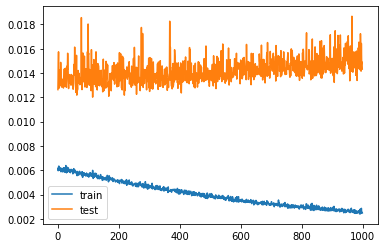

12/12 [==============================] - 0s 1ms/step


In [38]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

predicted_transactions = model.predict(X_test_reshaped)
predicted_transactions_rescaled = scaler_y.inverse_transform(predicted_transactions)


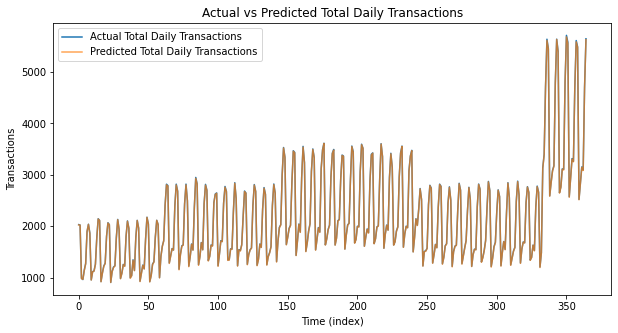

In [39]:
import matplotlib.pyplot as plt

y_test_rescaled = scaler_y.inverse_transform(y_test_scaled)

plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled[:, 0], label='Actual Total Daily Transactions')  # Use direct indexing for numpy arrays
plt.plot(predicted_transactions_rescaled[:, 0], label='Predicted Total Daily Transactions', alpha=0.7)
plt.title('Actual vs Predicted Total Daily Transactions')
plt.xlabel('Time (index)')
plt.ylabel('Transactions')
plt.legend()
plt.show()

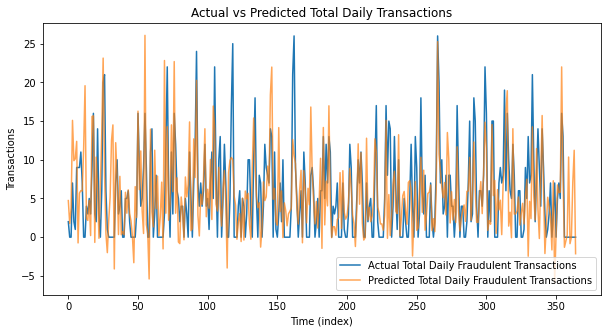

In [40]:
import matplotlib.pyplot as plt

y_test_rescaled = scaler_y.inverse_transform(y_test_scaled)

plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled[:, 1], label='Actual Total Daily Fraudulent Transactions')  # Use direct indexing for numpy arrays
plt.plot(predicted_transactions_rescaled[:, 1], label='Predicted Total Daily Fraudulent Transactions', alpha=0.7)
plt.title('Actual vs Predicted Total Daily Transactions')
plt.xlabel('Time (index)')
plt.ylabel('Transactions')
plt.legend()
plt.show()

In [73]:
input_value = 157673.36200000002

historical_df = pd.read_csv('average_daily_data.csv')
historical_df['diff'] = (historical_df['total_amount_per_day'] - input_value).abs()

closest_idx = historical_df['diff'].idxmin()

required_observations = 12

missing_observations = required_observations - (closest_idx + 1)

if closest_idx >= 12: 
    forecast_input_df = historical_df.iloc[closest_idx-28:closest_idx+1].copy()
else:
    additional_rows = historical_df.sample(n=missing_observations, replace=True) 
    forecast_input_df = pd.concat([additional_rows, historical_df.iloc[:closest_idx+1]])

forecast_input_df.loc[closest_idx, 'total_amount_per_day'] = input_value

historical_df.drop('diff', axis=1, inplace=True)
forecast_input_df.drop('diff', axis=1, inplace=True)
historical_df.drop('mm_dd', axis=1, inplace=True)
forecast_input_df.drop('mm_dd', axis=1, inplace=True)
historical_df.drop('total_daily_transactions', axis=1, inplace=True)
forecast_input_df.drop('total_daily_transactions', axis=1, inplace=True)
historical_df.drop('total_daily_fraud_transactions', axis=1, inplace=True)
forecast_input_df.drop('total_daily_fraud_transactions', axis=1, inplace=True)

forecast_input_scaled = scaler_x.transform(forecast_input_df)

forecast_input_reshaped = forecast_input_scaled.reshape((forecast_input_scaled.shape[0], 1, forecast_input_scaled.shape[1]))

forecast_input_values = forecast_input_reshaped.astype('float32')


predicted_outcomes = model.predict(forecast_input_values)

predicted_outcomes_rescaled = scaler_y.inverse_transform(predicted_outcomes)

print(f"Predicted Total Transactions: {predicted_outcomes_rescaled[0, 0]}")
print(f"Predicted Fraudulent Transactions: {predicted_outcomes_rescaled[0, 1]}")

1/1 [==============================] - 0s 18ms/step
Predicted Total Transactions: 2317.056884765625
Predicted Fraudulent Transactions: 7.865679740905762


In [76]:
model.save('finalDeepModel')

INFO:tensorflow:Assets written to: finalDeepModel/assets


INFO:tensorflow:Assets written to: finalDeepModel/assets


In [78]:
from joblib import dump, load
dump(scaler_x, 'scaler_x.joblib')

['scaler_x.joblib']

In [79]:
dump(scaler_y, 'scaler_y.joblib')

['scaler_y.joblib']